# TP 1:
##  CheckPoint 2
------

In [193]:
!pip install 'dtreeviz'

In [194]:
!wget https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_train.csv

--2023-10-05 23:05:15--  https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9788953 (9.3M) [text/plain]
Saving to: ‘hotels_train.csv.1’

hotels_train.csv.1  100%[===================>]   9.33M  --.-KB/s    in 0.1s    

2023-10-05 23:05:15 (95.2 MB/s) - ‘hotels_train.csv.1’ saved [9788953/9788953]



In [195]:
!wget https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_test.csv

--2023-10-05 23:05:15--  https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4432981 (4.2M) [text/plain]
Saving to: ‘hotels_test.csv.1’

hotels_test.csv.1   100%[===================>]   4.23M  --.-KB/s    in 0.08s   

2023-10-05 23:05:15 (52.5 MB/s) - ‘hotels_test.csv.1’ saved [4432981/4432981]



In [196]:
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Modify datasets

In [197]:
df = pd.read_csv("hotels_train.csv")

df_filtrado = df.copy()

In [198]:
df_filtrado = df_filtrado.drop('id', axis=1)
df_filtrado = df_filtrado.drop('company', axis=1)

Reemplazar por OTRO el pais

In [199]:
df_filtrado.children = df_filtrado.children.replace(np.nan, 0)

df_filtrado.agent = df_filtrado.agent.replace(np.nan, 9)

df_filtrado['country'] = df_filtrado['country'].replace(np.nan, 'OTRO')


In [200]:
df_filtrado = df_filtrado.replace({'adults': 0}, value=2)

In [201]:
df_filtrado = df_filtrado.replace({'distribution_channel': 'Undefined'}, value = 'TA/TO')
df_filtrado = df_filtrado.replace({'market_segment': 'Undefined'}, value = 'Online TA')

In [202]:
df_filtrado = df_filtrado.replace({'adr': -6.38}, value=0)
df_filtrado = df_filtrado.replace({'adr': 0}, value=df_filtrado['adr'].mean())

In [203]:
df_lead_mayor_600 = df_filtrado.loc[df_filtrado['lead_time'] > 600]
df_lead_menor_600 = df_filtrado.loc[df_filtrado['lead_time'] <= 600]
df_lead_mayor_600.drop_duplicates(subset=[col for col in df_filtrado.columns if col not in 'id'], inplace=True)
df_filtrado = pd.concat([df_lead_mayor_600, df_lead_menor_600], ignore_index=True)

<ipython-input-203-8df15c74c320>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [204]:
df_filtrado = df_filtrado.replace(to_replace= {'required_car_parking_spaces':3}, value=0)
df_filtrado = df_filtrado.replace(to_replace= {'required_car_parking_spaces':8}, value=0)

## CODIFICACION


In [205]:
df_encodeado = pd.get_dummies(df_filtrado, columns=["hotel", "arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type", "customer_type"], drop_first=False)
df_encodeado.head(3)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,626,2016,46,7,1,2,2,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,608,2017,10,9,0,2,2,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,605,2016,43,17,1,2,2,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [206]:
df_trabajo_x=df_encodeado.drop(['is_canceled'], axis='columns', inplace=False)

df_trabajo_y = df_encodeado['is_canceled'].copy()

x_train, x_valid, y_train, y_valid = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=1) #0.3

## Busqueda de hiperparametros

In [207]:
# # # ##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
# from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import make_scorer, f1_score

# #Cantidad de combinaciones que quiero porbar
# n=5 #5

# #Conjunto de parámetros que quiero usar
# params_grid = {'criterion':['gini', 'entropy'],
#                #'min_samples_leaf':list(range(1,4)),
#                #'min_samples_split': list(range(2,10)),
#                'min_samples_leaf':[1],
#                'min_samples_split': [2],
#                'ccp_alpha':np.linspace(0,0.001,10),
#                'max_depth':list(range(14,16))}


# #Cantidad de splits para el Cross Validation
# folds=5 #20

# #Kfold estratificado
# kfoldcv = StratifiedKFold(n_splits=folds)

# #Clasificador
# base_tree = DecisionTreeClassifier()

# #Metrica que quiero optimizar F1 Score
# scorer_fn = make_scorer(f1_score)

# #Random Search Cross Validation
# randomcv = RandomizedSearchCV(estimator=base_tree,
#                               param_distributions = params_grid,
#                               scoring=scorer_fn,
#                               cv=kfoldcv,
#                               n_iter=n)

# #Busco los hiperparamtros que optimizan F1 Score
# randomcv.fit(x_train,y_train);

In [208]:
# #Mejores hiperparametros del arbol
# print(randomcv.best_params_)
# #Mejor métrica
# print(randomcv.best_score_)

In [209]:
# tree_model = tree.DecisionTreeClassifier(criterion=randomcv.best_params_['criterion'],
#                                          max_depth = randomcv.best_params_['max_depth'],
#                                          ccp_alpha=randomcv.best_params_['ccp_alpha'],
#                                          min_samples_leaf=randomcv.best_params_['min_samples_leaf'],
#                                          min_samples_split=randomcv.best_params_['min_samples_split'])
# #Entrenamos el modelo
# model = tree_model.fit(X = x_train.sort_index(axis=1), y = y_train)

In [210]:
tree_model = tree.DecisionTreeClassifier(criterion='gini',
                                         max_depth = 14,
                                        #  ccp_alpha=0.00011111111111111112,
                                         ccp_alpha=0.00011111,
                                         min_samples_leaf=1,
                                         min_samples_split=2)
#fit model
model = tree_model.fit(X = x_train.sort_index(axis=1), y = y_train)

## Entrenamiento y predicción

In [211]:
y_pred = model.predict(x_valid.sort_index(axis=1))
#Valores Predichos
y_pred

array([1, 0, 0, ..., 0, 1, 1])

Text(50.722222222222214, 0.5, 'True')

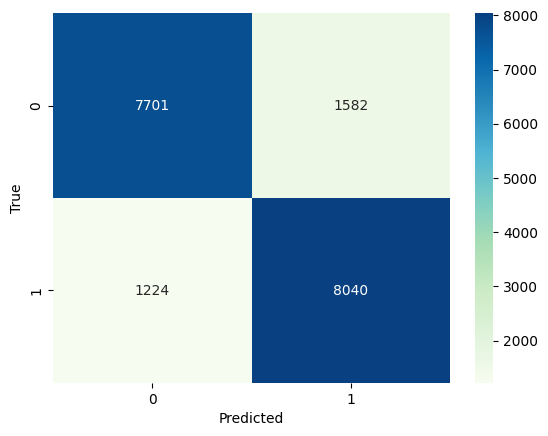

In [212]:
tabla=confusion_matrix(y_valid, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [213]:
accuracy=accuracy_score(y_valid,y_pred)
recall=recall_score(y_valid,y_pred)
f1=f1_score(y_valid,y_pred,)
precision=precision_score(y_valid,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8487086860408691
Recall: 0.8678756476683938
Precision: 0.8355851174392018
f1 score: 0.8514243354866038


In [214]:
print(classification_report(y_valid,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      9283
           1       0.84      0.87      0.85      9264

    accuracy                           0.85     18547
   macro avg       0.85      0.85      0.85     18547
weighted avg       0.85      0.85      0.85     18547



## Modificando el dataset de test.

In [215]:
df_test = pd.read_csv("hotels_test.csv")

df_test_filtrado = df_test.copy()

In [216]:
df_test_ids = df_test_filtrado['id'].copy()
df_test_filtrado = df_test_filtrado.drop('id', axis=1)
df_test_filtrado = df_test_filtrado.drop('company', axis=1)
df_test_filtrado = df_test_filtrado.drop('reservation_status_date', axis=1)

In [217]:
df_test_filtrado['country'] = df_test_filtrado['country'].replace(np.nan, 'OTRO')
df_test_filtrado.agent = df_test_filtrado.agent.replace(np.nan, 9)
df_test_filtrado.children = df_test_filtrado.children.replace(np.nan, 0)

In [218]:
lista_paises_unicos_test = df_test_filtrado['country'].unique()
lista_paises_unicos = df_filtrado['country'].unique()
conjunto1 = set(lista_paises_unicos)
conjunto2 = set(lista_paises_unicos_test)


# Obtener los elementos que están en conjunto1 pero no en conjunto2
elementos_en_lista1_no_en_lista2 = list(conjunto2 - conjunto1)
print(elementos_en_lista1_no_en_lista2)

df_test_filtrado["country"] = df_test_filtrado["country"].replace(to_replace=elementos_en_lista1_no_en_lista2, value="OTRO")

['BFA', 'NIC', 'TMP', 'MLI', 'ATF', 'SMR', 'SLV', 'KHM', 'DMA', 'DJI', 'UZB', 'ASM']


In [219]:
df_test_filtrado["adr"] = df_test_filtrado["adr"].replace(to_replace=0, value=df_filtrado['adr'].median())
df_test_filtrado["adults"] = df_test_filtrado["adults"].replace(to_replace=0, value=2)

In [220]:
df_test_encodeado = pd.get_dummies(df_test_filtrado, columns=["hotel", "arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type", "customer_type"], drop_first=False)


In [221]:
lista = df_test_encodeado.columns
columnas_faltantes = []
for colum in df_encodeado.columns:
  if(colum not in lista and colum != "is_canceled"):
    print(colum)
    columnas_faltantes.append(colum)

for colum_faltante in columnas_faltantes:
  df_test_encodeado[colum_faltante] = 0

country_ARM
country_AZE
country_BEN
country_CIV
country_COM
country_ETH
country_FJI
country_FRO
country_GTM
country_HND
country_KEN
country_KNA
country_MDG
country_MNE
country_MUS
country_MYT
country_NAM
country_PAN
country_PYF
country_SDN
country_SYC
country_SYR
country_TGO
country_UMI
country_VGB
country_ZMB
assigned_room_type_L


## Predicciónd el dataset de test:

In [222]:
test_pred_2 = model.predict(df_test_encodeado.sort_index(axis=1))
#Valores Predichos
test_pred_2

array([1, 1, 0, ..., 1, 1, 0])

In [223]:
data = {'id': df_test_ids, 'is_canceled': test_pred_2}
df_final_finalisimo = pd.DataFrame(data)

In [224]:
df_final_finalisimo.to_csv('submission.csv', index=False)

In [225]:
plt.figure(figsize=(100,100))

tree_plot_completo=tree.plot_tree(model,
                                feature_names=df_test_encodeado.columns.to_list(),
                                filled=True,
                                rounded=True,
                                class_names=['No Cancelado','Cancelado'],
                                 max_depth = 3)